## **Setting Things Up**

**1 If you haven't already, please hit :**

`File > Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


**2 In order to use a GPU with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then set the hardware accelerator dropdown to GPU. This can significantly speed up the training process.**

**3 In order to have enough memory with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then select High-RAM in the Runtime shape dropdown.**

To facilitate your initial progress, we have included a ready-to-use code on Google Colab for this problem. It allows you to get started immediately without the need to install any software libraries. Additionally, if you prefer not to use Google Colab and prefer setting up your own programming environment or employing alternative methods, the provided files and code will still be valuable.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# -*-coding:utf8 -*-
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

from tensorflow.python import keras
from keras.layers import Dense, Flatten, Conv2D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras import Model, Input, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change to your personal project address
%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction


## **1 Data Processing**

In [ ]:
var = "total score"
# var = "safety score"
# var = "performance score"
# var = "interior score"
# var = "critics score"

In [ ]:
# read info_data
file_name = "parametric data 2571 normalize " + var + ".csv"
info_data = pd.read_csv(file_name)
# get numpy matrix which only contains data (do not contain the title)
info_data = np.array(info_data)
print(info_data.shape)  # (2571, 310)
print(len(info_data))
print(info_data.shape[1])

(2571, 310)
2571
310


In [ ]:
# Input Parametric Data (2571x303)
# column 0: origin index
# column 1: model name
# column 2-303: parametric feature
# column 304: total score
# column 305: critics score
# column 306: performance score
# column 307: interior score
# column 308: safety score
# column 309: data split index => 1: train data; 2: validation data; 3:test data

In [ ]:
# train data shuffle index
num1 = 2055
idx1 = tf.range(num1)
idx1 = tf.random.shuffle(idx1)
# print(idx1)
# print(idx1[0])
with tf.compat.v1.Session():
    index1 = idx1.numpy()
# print(index1.shape)
# print(index1[0])

# validation data shuffle index
num2 = 258
idx2 = tf.range(num2)
idx2 = tf.random.shuffle(idx2)
# print(idx2)
# print(idx2[0])
with tf.compat.v1.Session():
    index2 = idx2.numpy()
# print(index2.shape)
# print(index2[0])

# test data shuffle index
num3 = 258
idx3 = tf.range(num3)
idx3 = tf.random.shuffle(idx3)
# print(idx3)
# print(idx3[0])
with tf.compat.v1.Session():
    index3 = idx3.numpy()
# print(index3.shape)
# print(index3[0])

In [ ]:
# assign the parametric data
# To predict the total score, you will need to assign the y variable using the values in column 304 of the parametric data.
# column 304: total score
# column 305: critics score
# column 306: performance score
# column 307: interior score
# column 308: safety score

x_train_tab = np.zeros((num1, 302))
y_train_tab = np.zeros((num1, 1))
for i in range(num1):
  x_train_tab[i] = np.array(info_data[index1[i], 2:304], dtype=float)
  y_train_tab[i] = np.array(info_data[index1[i], 304], dtype=float)
x_train_tab = tf.convert_to_tensor(x_train_tab)
y_train_tab = tf.convert_to_tensor(y_train_tab)
x_train = x_train_tab
y_train = y_train_tab
print(x_train.shape)
print(y_train.shape)

x_validation_tab = np.zeros((num2, 302))
y_validation_tab = np.zeros((num2, 1))
for i in range(num2):
  x_validation_tab[i] = np.array(info_data[index2[i] + num1, 2:304], dtype=float)
  y_validation_tab[i] = np.array(info_data[index2[i] + num1, 304], dtype=float)
x_validation_tab = tf.convert_to_tensor(x_validation_tab)
y_validation_tab = tf.convert_to_tensor(y_validation_tab)
x_validation = x_validation_tab
y_validation = y_validation_tab
print(x_validation.shape)
print(y_validation.shape)

x_test_tab = np.zeros((num3, 302))
y_test_tab = np.zeros((num3, 1))
for i in range(num3):
  x_test_tab[i] = np.array(info_data[index3[i] + num1 + num2, 2:304], dtype=float)
  y_test_tab[i] = np.array(info_data[index3[i] + num1 + num2, 304], dtype=float)
x_test_tab = tf.convert_to_tensor(x_test_tab)
y_test_tab = tf.convert_to_tensor(y_test_tab)
x_test = x_test_tab
y_test = y_test_tab
print(x_test.shape)
print(y_test.shape)

(2055, 302)
(2055, 1)
(258, 302)
(258, 1)
(258, 302)
(258, 1)


## **2 Construct Parametric Model**

In [ ]:
# construct the MLP model
adam_optimizer = Adam(learning_rate=0.001)
rms_prop_optimizer = RMSprop(learning_rate=0.001)
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)

In [ ]:
data = x_train[0]

model = tf.keras.Sequential([
    layers.Dense(302, activation='relu', input_shape=data.shape, name='tab_dense1'),
    layers.Dropout(0.3, name='tab_dropout1'),# total score => 0.3 ; other score => 0.25
    layers.Dense(100, activation='relu', name='tab_dense2'),
    # layers.Dropout(0.1, name='tab_dropout2'),
    layers.Dense(1, name='tab_dense3')
],name='Parametric_Model')

model.compile(
    optimizer=adam_optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse', 'mae']
)

model.summary()


Model: "Parametric_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_dense1 (Dense)          (None, 302)               91506     
                                                                 
 tab_dropout1 (Dropout)      (None, 302)               0         
                                                                 
 tab_dense2 (Dense)          (None, 100)               30300     
                                                                 
 tab_dense3 (Dense)          (None, 1)                 101       
                                                                 
Total params: 121,907
Trainable params: 121,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
    min_lr = 0.0000001
    if epoch < 5:
        return lr
    else:
        if lr < min_lr:
            lr = min_lr
            return lr
        else:
          return lr * tf.math.exp(-0.015)



In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=40, monitor="val_loss", restore_best_weights=True, verbose=1)
EPOCHS = 500
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(x_validation, y_validation),
                    verbose=2, callbacks=[early_stop, reduce_lr])
print(history)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/500
65/65 - 2s - loss: 0.0782 - rmse: 0.2797 - mse: 0.0782 - mae: 0.1877 - val_loss: 0.0145 - val_rmse: 0.1206 - val_mse: 0.0145 - val_mae: 0.0970 - lr: 0.0010 - 2s/epoch - 29ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
65/65 - 0s - loss: 0.0174 - rmse: 0.1319 - mse: 0.0174 - mae: 0.1043 - val_loss: 0.0168 - val_rmse: 0.1296 - val_mse: 0.0168 - val_mae: 0.1077 - lr: 0.0010 - 462ms/epoch - 7ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
65/65 - 0s - loss: 0.0158 - rmse: 0.1256 - mse: 0.0158 - mae: 0.0998 - val_loss: 0.0173 - val_rmse: 0.1316 - val_mse: 0.0173 - val_mae: 0.1085 - lr: 0.0010 - 379ms/epoch - 6ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
65/65 - 0s - loss: 0.0135 - rmse: 0.1163 - mse: 0.0135 - mae: 0.0924 - val_loss: 0.0168 - v

## **3 Model Evaluation and Results**

In [ ]:
test_loss, test_rmse, test_mse, test_mae = model.evaluate(x_test, y_test, verbose=2)
validation_loss, validation_rmse, validation_mse, validation_mae = model.evaluate(x_validation, y_validation, verbose=2)
train_loss, train_rmse, train_mse, train_mae = model.evaluate(x_train, y_train, verbose=2)

9/9 - 0s - loss: 0.0060 - rmse: 0.0777 - mse: 0.0060 - mae: 0.0594 - 49ms/epoch - 5ms/step
9/9 - 0s - loss: 0.0064 - rmse: 0.0801 - mse: 0.0064 - mae: 0.0624 - 111ms/epoch - 12ms/step
65/65 - 0s - loss: 1.8288e-04 - rmse: 0.0135 - mse: 1.8288e-04 - mae: 0.0103 - 290ms/epoch - 4ms/step


In [ ]:
result = model.predict(x_test)
# print(result)
# print(result[0])

9/9 [==============================] - 0s 3ms/step


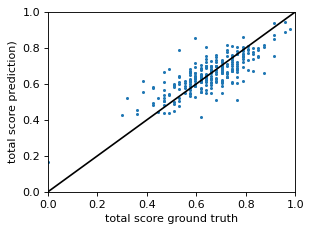

In [ ]:
figure(figsize=(4, 3), dpi=80)
plt.scatter(y_test, result, s=3)
# plt.legend()
x = [0, 1]
y = [0, 1]
plt.plot(x, y, color="black")
plt.xlabel(var + ' ground truth')
plt.ylabel(var + ' prediction)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [ ]:
from math import nan
test = np.array(y_test).T
# print(test)
predict = np.array(result).T

correlation_matrix = np.corrcoef(test, predict)
print(correlation_matrix)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
##range: 0.8199158648859902

print (r_squared)

[[1.         0.78414247]
 [0.78414247 1.        ]]
0.6148794105300015


## **4 Store the Model & Train, Validation and Test Results**

In [ ]:
output = pd.DataFrame()
idx = 0
output.loc[idx, 'train_rmse'] = train_rmse
output.loc[idx, 'train_mse'] = train_mse
output.loc[idx, 'train_mae'] = train_mae

output.loc[idx, 'validation_rmse'] = validation_rmse
output.loc[idx, 'validation_mse'] = validation_mse
output.loc[idx, 'validation_mae'] = validation_mae

output.loc[idx, 'test_rmse'] = test_rmse
output.loc[idx, 'test_mse'] = test_mse
output.loc[idx, 'test_mae'] = test_mae

output.loc[idx, 'r^2'] = r_squared
pd.set_option('display.max_columns', None)
print(output)

output.to_csv('parametric_unimodal_value.csv')

   train_rmse  train_mse  train_mae  validation_rmse  validation_mse  \
0    0.020156   0.000406   0.015735         0.078939        0.006231   

   validation_mae  test_rmse  test_mse  test_mae       r^2  
0         0.06118   0.075095  0.005639  0.058396  0.641512  


In [ ]:
# store the model
# summarize the loaded model
model.summary()
# save the best performing model to file
model.save('model weight/' + var + '_Par.h5')

Model: "Parametric_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_dense1 (Dense)          (None, 302)               91506     
                                                                 
 tab_dropout1 (Dropout)      (None, 302)               0         
                                                                 
 tab_dense2 (Dense)          (None, 100)               30300     
                                                                 
 tab_dense3 (Dense)          (None, 1)                 101       
                                                                 
Total params: 121,907
Trainable params: 121,907
Non-trainable params: 0
_________________________________________________________________
